In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Algo LumberJack FROM KEREAS with memory\nLumberJack Jyss (c)')

Algo LumberJack FROM KEREAS with memory
LumberJack Jyss (c)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import pandas as pd
from pandas import read_csv
import math
import keras
import sklearn
from keras.models import *
from keras.layers import *
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
%matplotlib inline

Using TensorFlow backend.


In [4]:
nbneurons = 500
ntimstep = 1
nbfeature = 1
activation = 'sigmoid' #'tanh' # 'sigmoid'
Algo = ReLU #LSTM SimpleRNN SimpleRNNCell ReLU RNN
batchsize = 1
nbepochs = 5000
loop = 500

In [5]:
# Setting the data
start = pd.to_datetime('2016-03-31')
end = pd.to_datetime('2019-03-28')
delta = round((end-start).days)
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("Période d'étude : ",delta)
print('Sur un découpage 80% - 20% de la période : ')
print('Bloc 1 : ',bloc1,' jours \nBloc 2 :',bloc2,' jours')
print('Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés')

Période d'étude :  1092
Sur un découpage 80% - 20% de la période : 
Bloc 1 :  874  jours 
Bloc 2 : 218  jours
Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés


In [6]:
dataset = web.DataReader('AMZN','yahoo',start,end)
#spy_etf = web.DataReader('SPY','yahoo',start,end)
dataset = dataset.drop(['Low','High','Volume','Close'],axis=1)

In [7]:
dataset.head()

,Open,Adj Close
Date,,
2016-03-31,599.280029,593.640015
2016-04-01,590.489990,598.500000
2016-04-04,599.000000,593.190002
2016-04-05,590.770020,586.140015
2016-04-06,587.520020,602.080017


In [8]:
#dataset
data=pd.DataFrame(dataset)
#data.loc[:,0] = dataset.loc[:,0]
#data.loc[:,1] = dataset[:,1]#.shift(-1)
data.dropna()
data.head()

,Open,Adj Close
Date,,
2016-03-31,599.280029,593.640015
2016-04-01,590.489990,598.500000
2016-04-04,599.000000,593.190002
2016-04-05,590.770020,586.140015
2016-04-06,587.520020,602.080017


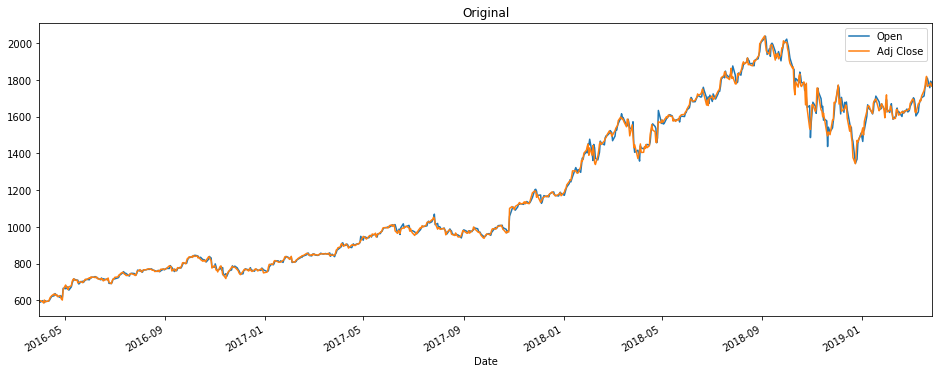

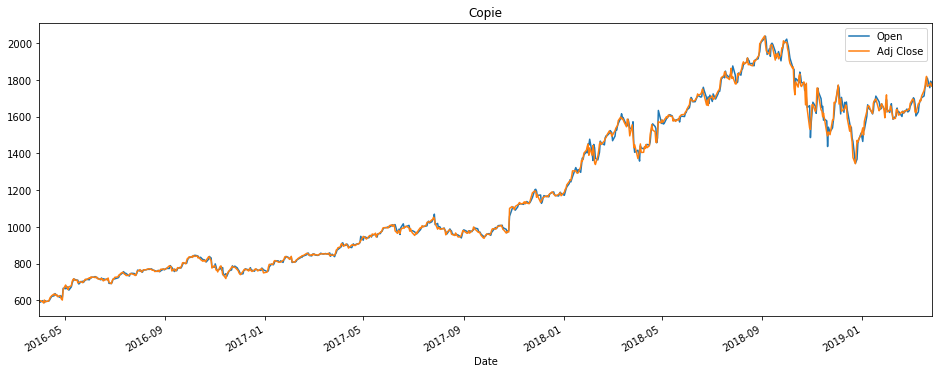

In [9]:
dataset.plot(figsize=(16,6),title='Original')
data.plot(figsize=(16,6),title='Copie')

In [10]:
train_X = data.iloc[0:bloc1,0]
test_X = data.iloc[bloc1:,0]
train_y = data.iloc[0:bloc1,1]
test_y = data.iloc[bloc1:,1]

In [ ]:
input_train = train_X.values
output_train = train_y.values
input_test = test_y.values
output_test = test_y.values

In [ ]:
input_train = input_train.astype(float)
output_train = output_train.astype(float)
input_test = input_test.astype(float)
output_test = output_test.astype(float)

In [ ]:
input_train = input_train.reshape(-1,1)
output_train = output_train.reshape(-1,1)
input_test = input_test.reshape(-1,1)
output_test = output_test.reshape(-1,1)

In [ ]:
input_train = input_train.reshape(len(input_train),1,1)
output_train = output_train.reshape(len(output_train),1,1)
input_test = input_test.reshape(len(input_test),1,1)
output_test = output_test.reshape(len(output_test),1,1)

In [ ]:
input_train_shape = input_train.shape
output_train_shape = output_train.shape
input_test_shape = input_test.shape
output_test_shape = output_test.shape

## Step 1. Define Network

The first step is to define your network.

Neural networks are defined in Keras as a sequence of layers. The container for these layers is the Sequential class.

The first step is to create an instance of the Sequential class. Then you can create your layers and add them in the order that they should be connected. The LSTM recurrent layer comprised of memory units is called LSTM(). A fully connected layer that often follows LSTM layers and is used for outputting a prediction is called Dense().

model = Sequential()
model.add(LSTM(2))
model.add(Dense(1))

The first layer in the network must define the number of inputs to expect. Input must be three-dimensional, comprised of samples, timesteps, and features.

Samples. These are the rows in your data.
Timesteps. These are the past observations for a feature, such as lag variables.
Features. These are columns in your data.
Assuming your data is loaded as a NumPy array, you can convert a 2D dataset to a 3D dataset using the reshape() function in NumPy.

In [ ]:
input_train_shape,output_train_shape,input_test_shape,output_test_shape

((754, 1, 1), (754, 1, 1), (0, 1, 1), (0, 1, 1))

LSTM layers can be stacked by adding them to the Sequential model. Importantly, when stacking LSTM layers, we must output a sequence rather than a single value for each input so that the subsequent LSTM layer can have the required 3D input. We can do this by setting the return_sequences argument = True.

In [ ]:
model = Sequential()
model.add(Algo(nbneurons,input_shape=(ntimstep,nbfeature)))
model.add(Dense(1))
model.add(Activation('linear'))

The choice of activation function is most important for the output layer as it will define the format that predictions will take.

For example, below are some common predictive modeling problem types and the structure and standard activation function that you can use in the output layer:

Regression: Linear activation function, or ‘linear’, and the number of neurons matching the number of outputs.
Binary Classification (2 class): Logistic activation function, or ‘sigmoid’, and one neuron the output layer.
Multiclass Classification (>2 class): Softmax activation function, or ‘softmax’, and one output neuron per class value, assuming a one-hot encoded output pattern.

## Step 2. Compile Network

Once we have defined our network, we must compile it.

Compilation is an efficiency step. It transforms the simple sequence of layers that we defined into a highly efficient series of matrix transforms in a format intended to be executed on your GPU or CPU, depending on how Keras is configured.

Think of compilation as a precompute step for your network. It is always required after defining a model.

Compilation requires a number of parameters to be specified, specifically tailored to training your network. Specifically, the optimization algorithm to use to train the network and the loss function used to evaluate the network that is minimized by the optimization algorithm.

For example, below is a case of compiling a defined model and specifying the stochastic gradient descent (sgd) optimization algorithm and the mean squared error (mean_squared_error) loss function, intended for a regression type problem.

In [ ]:
#algorithm = 'SGD(lr=0.1, momentum=0.3)'
#model.compile(optimizer=algorithm, loss='mean_squared_error')

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

The type of predictive modeling problem imposes constraints on the type of loss function that can be used.

For example, below are some standard loss functions for different predictive model types:

Regression: Mean Squared Error or ‘mean_squared_error’.

Binary Classification (2 class): Logarithmic Loss, also called cross entropy or ‘binary_crossentropy‘.

Multiclass Classification (>2 class): Multiclass Logarithmic Loss or ‘categorical_crossentropy‘.

The most common optimization algorithm is stochastic gradient descent, but Keras also supports a suite of other state-of-the-art optimization algorithms that work well with little or no configuration.

Perhaps the most commonly used optimization algorithms because of their generally better performance are:

Stochastic Gradient Descent, or ‘sgd‘, that requires the tuning of a learning rate and momentum.

ADAM, or ‘adam‘, that requires the tuning of learning rate.

RMSprop, or ‘rmsprop‘, that requires the tuning of learning rate.

Finally, you can also specify metrics to collect while fitting your model in addition to the loss function. Generally, the most useful additional metric to collect is accuracy for classification problems. The metrics to collect are specified by name in an array.

## Step 3. Fit Network

Once the network is compiled, it can be fit, which means adapt the weights on a training dataset.

Fitting the network requires the training data to be specified, both a matrix of input patterns, X, and an array of matching output patterns, y.

The network is trained using the backpropagation algorithm and optimized according to the optimization algorithm and loss function specified when compiling the model.

The backpropagation algorithm requires that the network be trained for a specified number of epochs or exposures to the training dataset.

Each epoch can be partitioned into groups of input-output pattern pairs called batches. This defines the number of patterns that the network is exposed to before the weights are updated within an epoch. It is also an efficiency optimization, ensuring that not too many input patterns are loaded into memory at a time.



In [ ]:
#for i in range(loop):
history = model.fit(input_train, output_train, batch_size=batchsize, epochs=nbepochs,verbose=1)
#    model.reset_states()
#    print('Loop N°',i,'/',loop)

Epoch 1/5000
754/754 [==============================] - 1s 2ms/step - loss: 503875.7485 - acc: 0.0000e+00
Epoch 2/5000
754/754 [==============================] - 1s 1ms/step - loss: 284569.1296 - acc: 0.0000e+00
Epoch 3/5000
754/754 [==============================] - 1s 1ms/step - loss: 203103.4620 - acc: 0.0000e+00
Epoch 4/5000
754/754 [==============================] - 1s 1ms/step - loss: 178421.0316 - acc: 0.0000e+00
Epoch 5/5000
754/754 [==============================] - 1s 1ms/step - loss: 172737.4963 - acc: 0.0000e+00
Epoch 6/5000
754/754 [==============================] - 1s 1ms/step - loss: 171774.8138 - acc: 0.0000e+00
Epoch 7/5000
754/754 [==============================] - 1s 1ms/step - loss: 171583.7672 - acc: 0.0000e+00
Epoch 8/5000
754/754 [==============================] - 1s 1ms/step - loss: 171474.3282 - acc: 0.0000e+00
Epoch 9/5000
754/754 [==============================] - 1s 1ms/step - loss: 171481.4109 - acc: 0.0000e+00
Epoch 10/5000
754/754 [=======================

Once fit, a history object is returned that provides a summary of the performance of the model during training. This includes both the loss and any additional metrics specified when compiling the model, recorded each epoch.

Training can take a long time, from seconds to hours to days depending on the size of the network and the size of the training data.

By default, a progress bar is displayed on the command line for each epoch. This may create too much noise for you, or may cause problems for your environment, such as if you are in an interactive notebook or IDE.

You can reduce the amount of information displayed to just the loss each epoch by setting the verbose argument to 2. You can turn off all output by setting verbose to 0.

## Step 4. Evaluate Network

Once the network is trained, it can be evaluated.

The network can be evaluated on the training data, but this will not provide a useful indication of the performance of the network as a predictive model, as it has seen all of this data before.

We can evaluate the performance of the network on a separate dataset, unseen during testing. This will provide an estimate of the performance of the network at making predictions for unseen data in the future.

The model evaluates the loss across all of the test patterns, as well as any other metrics specified when the model was compiled, like classification accuracy. A list of evaluation metrics is returned.

In [ ]:
evaluation = model.evaluate(input_test, output_test,verbose=2,batch_size=batchsize)
evaluation

## Step 5. Make Predictions

Once we are satisfied with the performance of our fit model, we can use it to make predictions on new data.

This is as easy as calling the predict() function on the model with an array of new input patterns.

In [ ]:
X=[20,21,22,23,24,25,26,27,28,29,30]
X = np.array(X)
X = X.reshape(len(X),1,1)

In [ ]:
predictions = model.predict(X,verbose=1)
predictions


The predictions will be returned in the format provided by the output layer of the network.

In the case of a regression problem, these predictions may be in the format of the problem directly, provided by a linear activation function.

For a binary classification problem, the predictions may be an array of probabilities for the first class that can be converted to a 1 or 0 by rounding.

For a multiclass classification problem, the results may be in the form of an array of probabilities (assuming a one hot encoded output variable) that may need to be converted to a single class output prediction using the argmax() NumPy function.

Alternately, for classification problems, we can use the predict_classes() function that will automatically convert uncrisp predictions to crisp integer class values.

In [ ]:
resultats=list()
for i in range(len(predictions)):
    resultats.append(predictions.reshape(len(predictions))[i])

In [ ]:
plt.plot(resultats)